In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from geopy.distance import geodesic
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import joblib

In [65]:
DATA_PATH = "../data"

In [66]:
def plot_bars(
    attribute: str, figsize: tuple[int] = (10, 4), data=None, order=None
) -> None:
    sns.set_theme(style="darkgrid")
    fig, axes = plt.subplots(1, 2, figsize=figsize)  # 1 row, 2 columns
    grouped = data.groupby([attribute, "DELAYED"]).size().unstack()

    if order is not None:
        grouped = grouped.reindex(order)

    grouped.plot.bar(
        stacked=True, ax=axes[0], title=f"Delayed shipments by {attribute} (Counts)"
    )
    axes[0].set_ylabel("Count")

    grouped_normalized = grouped.div(grouped.sum(axis=1), axis=0) * 100
    grouped_normalized.plot.bar(
        stacked=True, ax=axes[1], title=f"Delayed shipments by {attribute} (%)"
    )
    axes[1].set_ylabel("Percentage")

    plt.tight_layout()
    plt.show()

In [67]:
def distplots(feature: str, data=None):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    sns.histplot(data=data, x=feature, kde=True, fill=True, hue="DELAYED", ax=axes[0])
    sns.boxplot(data=data, x="DELAYED", y=feature, ax=axes[1])
    plt.show()

In [68]:
date_cols = [
    "FIRST_COLLECTION_SCHEDULE_EARLIEST",
    "FIRST_COLLECTION_SCHEDULE_LATEST",
    "LAST_DELIVERY_SCHEDULE_EARLIEST",
    "LAST_DELIVERY_SCHEDULE_LATEST",
]

shipment_bookings = pd.read_csv(
    f"{DATA_PATH}/Shipment_bookings.csv", parse_dates=date_cols
)
shipment_bookings.head()

,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST
0,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,-3.648558,2023-10-06 09:45:00+00:00,2023-10-06 10:00:00+00:00,2023-10-09 09:55:00+00:00,2023-10-09 10:25:00+00:00
1,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231217-275004,CAUK000660,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.764125,-1.740145,51.398851,-1.231993,2023-12-19 14:20:00+00:00,2023-12-19 16:00:00+00:00,2023-12-20 06:00:00+00:00,2023-12-20 08:56:00+00:00
2,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231210-272018,CAUK000435,Tractor Unit,Box 44ft,BD5 8LZ,EN3 7QP,53.767302,-1.746560,51.660700,-0.022247,2023-12-14 01:20:00+00:00,2023-12-14 03:00:00+00:00,2023-12-14 07:03:00+00:00,2023-12-14 10:43:00+00:00
3,40415fe3-e446-4d1e-b141-3698b0dc47f3,SEZHUK-231211-272127,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,HP22 5BL,NG31 7UH,51.779657,-0.772897,52.888113,-0.634948,2023-12-13 09:00:00+00:00,2023-12-13 09:30:00+00:00,2023-12-13 15:30:00+00:00,2023-12-13 16:00:00+00:00
4,39a4e234-5d35-4d94-8e8a-b8bf6fe13953,SEZHUK-231025-256168,CAUK000155,Tractor Unit,Curtain Side,CV23 8BQ,G75 0ZZ,52.334853,-1.180450,55.735089,-4.168719,2023-11-07 14:00:00+00:00,2023-11-07 15:00:00+00:00,2023-11-07 23:00:00+00:00,2023-11-07 23:59:00+00:00


In [69]:
shipment_bookings["FIRST_COLLECTION_SCHEDULE_EARLIEST"].min()

Timestamp('2023-09-29 14:00:00+0000', tz='UTC')

In [70]:
shipment_bookings.columns

Index(['PROJECT_ID', 'SHIPMENT_NUMBER', 'CARRIER_DISPLAY_ID', 'VEHICLE_SIZE',
       'VEHICLE_BUILD_UP', 'FIRST_COLLECTION_POST_CODE',
       'LAST_DELIVERY_POST_CODE', 'FIRST_COLLECTION_LATITUDE',
       'FIRST_COLLECTION_LONGITUDE', 'LAST_DELIVERY_LATITUDE',
       'LAST_DELIVERY_LONGITUDE', 'FIRST_COLLECTION_SCHEDULE_EARLIEST',
       'FIRST_COLLECTION_SCHEDULE_LATEST', 'LAST_DELIVERY_SCHEDULE_EARLIEST',
       'LAST_DELIVERY_SCHEDULE_LATEST'],
      dtype='object')

In [71]:
shipment_bookings.shape

(3245, 15)

In [72]:
gps = pd.read_csv(f"{DATA_PATH}/GPS_data.csv", parse_dates=["RECORD_TIMESTAMP"])

In [73]:
gps.head()

,SHIPMENT_NUMBER,LAT,LON,RECORD_TIMESTAMP
0,SEZHUK-230918-245388,53.291931,-1.072948,2023-10-09 19:25:00+01:00
1,SEZHUK-230918-245388,53.400404,-1.078563,2023-10-09 19:40:00+01:00
2,SEZHUK-230918-245388,53.574182,-1.215761,2023-10-09 19:55:00+01:00
3,SEZHUK-230918-245388,53.706805,-1.336503,2023-10-09 20:10:00+01:00
4,SEZHUK-230918-245388,53.747501,-1.640298,2023-10-09 20:25:00+01:00


Assuming that the delivery is considered "delivered" at the latest timestamp in the GPS data for its shipment number, we want to calculate whether the maximum `RECORD_TIMESTAMP` in the GPS data is greater than `LAST_DELIVERY_SCHEDULE_LATEST` for each shipment.

In [74]:
# Filter data to shipments  between October 1st and December 31st, 2023

shipment_bookings = shipment_bookings[
    shipment_bookings["FIRST_COLLECTION_SCHEDULE_EARLIEST"].between(
        "2023-10-01 00:00:00", "2024-12-31 23:59:59"
    )
]
print(
    f"Earliest collection date: {shipment_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'].min()}"
)
print(
    f"Latest collection date: {shipment_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'].max()}"
)

Earliest collection date: 2023-10-01 00:30:00+00:00
Latest collection date: 2023-12-31 00:30:00+00:00


In [75]:
def find_nearest_gps(shipment_data, gps_data):
    nearest_gps_timestamps = []
    for i, shipment in shipment_data.iterrows():
        shipment_gps = gps_data[
            (gps_data["SHIPMENT_NUMBER"] == shipment["SHIPMENT_NUMBER"])
        ]
        if shipment_gps.empty:
            nearest_gps_timestamps.append(None)
            continue
        shipment_gps["DISTANCE"] = shipment_gps.apply(
            lambda x: geodesic(
                (
                    x["LAT"],
                    x["LON"]
                ),
                (
                    shipment["LAST_DELIVERY_LATITUDE"],
                    shipment["LAST_DELIVERY_LONGITUDE"],
                ),
            ),
            axis=1,
        )
        nearest_gps_timestamps.append(
            shipment_gps.loc[shipment_gps["DISTANCE"].idxmin(), "RECORD_TIMESTAMP"]
        )
    return nearest_gps_timestamps

In [77]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print(f"Shape before: {shipment_bookings.shape}")
    shipment_bookings["NEAREST_GPS_TIMESTAMP"] = find_nearest_gps(shipment_bookings, gps)
    print(f"Shape after: {shipment_bookings.shape}")

Shape before: (3244, 16)
Shape after: (3244, 16)


In [14]:
# Adding the delayed column
shipment_bookings["DELAYED"] = (
    shipment_bookings["LAST_DELIVERY_SCHEDULE_LATEST"] + pd.Timedelta("30 minutes")
    < shipment_bookings["NEAREST_GPS_TIMESTAMP"]
)

In [15]:
# Check null counts
shipment_bookings.isnull().sum()

PROJECT_ID                            0
SHIPMENT_NUMBER                       0
CARRIER_DISPLAY_ID                    0
VEHICLE_SIZE                          0
VEHICLE_BUILD_UP                      0
FIRST_COLLECTION_POST_CODE            1
LAST_DELIVERY_POST_CODE               4
FIRST_COLLECTION_LATITUDE             0
FIRST_COLLECTION_LONGITUDE            0
LAST_DELIVERY_LATITUDE                0
LAST_DELIVERY_LONGITUDE               0
FIRST_COLLECTION_SCHEDULE_EARLIEST    0
FIRST_COLLECTION_SCHEDULE_LATEST      0
LAST_DELIVERY_SCHEDULE_EARLIEST       0
LAST_DELIVERY_SCHEDULE_LATEST         0
NEAREST_GPS_TIMESTAMP                 0
DELAYED                               0
dtype: int64

It seems there are no missing records in the GPS data as the DELAYED attribute is never null following the LEFT merge. Only postcodes are occasionally missing. Nice.

In [16]:
# Quick check of unique counts
shipment_bookings.select_dtypes(include="object").nunique()

PROJECT_ID                      49
SHIPMENT_NUMBER               3244
CARRIER_DISPLAY_ID              92
VEHICLE_SIZE                     6
VEHICLE_BUILD_UP                13
FIRST_COLLECTION_POST_CODE     154
LAST_DELIVERY_POST_CODE        432
NEAREST_GPS_TIMESTAMP         3137
dtype: int64

In [17]:
# Summary statistcs for numerical columns
shipment_bookings.select_dtypes(include="number").describe().T

,count,mean,std,min,25%,50%,75%,max
FIRST_COLLECTION_LATITUDE,3244.0,53.000927,0.854703,50.386450,52.322608,53.304842,53.634051,55.932081
FIRST_COLLECTION_LONGITUDE,3244.0,-1.580715,0.879247,-6.104285,-2.120660,-1.630808,-1.074008,1.397815
LAST_DELIVERY_LATITUDE,3244.0,52.465805,1.099989,50.228709,51.558294,52.371656,53.207122,57.653603
LAST_DELIVERY_LONGITUDE,3244.0,-1.511380,1.572387,-8.687242,-1.983264,-1.231993,-0.515011,1.457581


### Percentage of shipments delayed

In [18]:
delayed = round(shipment_bookings["DELAYED"].mean(), 2)
print(f"{delayed * 100}% of shipments are delayed.")

27.0% of shipments are delayed.


Note that this is calculated over the complete dataset, and does not account for invalid records that are removed below.

In [19]:
# Check for incorrect coordinates
shipment_bookings[
    (
        shipment_bookings["FIRST_COLLECTION_LATITUDE"]
        == shipment_bookings["LAST_DELIVERY_LATITUDE"]
    )
    & (
        shipment_bookings["FIRST_COLLECTION_LONGITUDE"]
        == shipment_bookings["LAST_DELIVERY_LONGITUDE"]
    )
].shape[0]

55

In [20]:
# shipment_bookings = shipment_bookings[
#     ~(
#         (shipment_bookings["FIRST_COLLECTION_LATITUDE"] == shipment_bookings["LAST_DELIVERY_LATITUDE"]) &
#         (shipment_bookings["FIRST_COLLECTION_LONGITUDE"] == shipment_bookings["LAST_DELIVERY_LONGITUDE"])
#     )
# ]
# shipment_bookings.head()

In [21]:
# Inspect rows with EARLIEST columns > LATEST columns
invalid_rows = shipment_bookings.loc[
    (
        shipment_bookings["FIRST_COLLECTION_SCHEDULE_EARLIEST"]
        > shipment_bookings["FIRST_COLLECTION_SCHEDULE_LATEST"]
    )
    | (
        shipment_bookings["LAST_DELIVERY_SCHEDULE_EARLIEST"]
        > shipment_bookings["LAST_DELIVERY_SCHEDULE_LATEST"]
    )
    | (
        shipment_bookings["LAST_DELIVERY_SCHEDULE_LATEST"]
        < shipment_bookings["FIRST_COLLECTION_SCHEDULE_EARLIEST"]
    ),
    [
        "SHIPMENT_NUMBER",
        "FIRST_COLLECTION_SCHEDULE_EARLIEST",
        "FIRST_COLLECTION_SCHEDULE_LATEST",
        "LAST_DELIVERY_SCHEDULE_EARLIEST",
        "LAST_DELIVERY_SCHEDULE_LATEST",
    ],
]

print(f"Number of rows with invalid dates: {invalid_rows.shape[0]}")
invalid_rows

Number of rows with invalid dates: 11


,SHIPMENT_NUMBER,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST
319,SEZHUK-231220-276089,2023-12-21 19:00:00+00:00,2023-12-21 20:00:00+00:00,2023-12-21 10:15:00+00:00,2023-12-21 10:45:00+00:00
456,SEZHUK-231215-274563,2023-12-16 10:00:00+00:00,2023-12-16 10:30:00+00:00,2023-12-15 16:30:00+00:00,2023-12-15 17:00:00+00:00
537,SEZHUK-231215-274632,2023-12-17 20:00:00+00:00,2023-12-17 21:00:00+00:00,2023-12-17 02:30:00+00:00,2023-12-17 03:00:00+00:00
755,SEZHUK-231011-251901,2023-10-16 14:00:00+00:00,2023-10-16 12:56:00+00:00,2023-10-17 19:55:00+00:00,2023-10-17 20:25:00+00:00
802,SEZHUK-231215-274628,2023-12-16 10:00:00+00:00,2023-12-16 10:30:00+00:00,2023-12-15 16:30:00+00:00,2023-12-15 17:00:00+00:00
850,SEZHUK-231215-274570,2023-12-17 18:00:00+00:00,2023-12-17 19:00:00+00:00,2023-12-17 00:30:00+00:00,2023-12-17 01:00:00+00:00
875,SEZHUK-231026-256940,2023-10-27 14:00:00+00:00,2023-10-27 13:00:00+00:00,2023-10-28 00:01:00+00:00,2023-10-28 00:31:00+00:00
926,SEZHUK-231216-274798,2023-12-21 03:30:00+00:00,2023-12-21 03:30:00+00:00,2023-12-20 22:30:00+00:00,2023-12-20 23:00:00+00:00
1091,SEZHUK-231215-274639,2023-12-16 10:00:00+00:00,2023-12-16 10:30:00+00:00,2023-12-15 16:30:00+00:00,2023-12-15 17:00:00+00:00
1858,SEZHUK-231018-253947,2023-10-18 14:00:00+00:00,2023-10-18 14:30:00+00:00,2023-10-18 10:30:00+00:00,2023-10-18 11:00:00+00:00


It's possible that these times have been switched over, but unless we know for certain, and as we need to handle invalid data in the test set, we'll leave these in.

In [22]:
# # Drop rows where the latest delivery date is before the earliest collection date
# shipment_bookings = shipment_bookings[
#     ~(shipment_bookings.index.isin(invalid_rows.index))
# ]

### Exploratory Analysis

#### Distance calculations

Here, the straight line distance is used in lieu of an estimated journey time from an API such as distancematrix.ai or the Google Maps API.

Ideally something like the below would be used instead. This would likely yield a much better predictor of delay (See distancematrix_api.ipynb for implementation)

```python
import requests
from config import DISTANCEMATRIX_API_KEY

def get_journey_time(lat1, lon1, lat2, lon2) -> dict:
    response = requests.get(f"https://distancematrix.ai/distancematrixaccurate?lat1={lat1}&lon1={lon1}&lat2={lat2}&lon2={lon2}&key={DISTANCEMATRIX_API_KEY}")
    distance = response.json()["distance"]["value"]
    journey_time = response.json()["journey_time"]["value"]

    return {"distance": distance, "journey_time": journey_time}


data["JOURNEY_TIME"] = data.apply(lambda row: get_journey_time(
    row["FIRST_COLLECTION_LATITUDE"],
    row["FIST_COLLECTION_LONGITUDE"],
    row["LAST_DELIVERY_LATITUDE"],
    row["LAST_DELIVERY_LONGITUDE"]
    )["journey_time"],
    axis=1
)
```

In [23]:
# Calculate distance between lat/lon coordinates.

shipment_bookings["DISTANCE"] = shipment_bookings.apply(
    lambda x: geodesic(
        (x["FIRST_COLLECTION_LATITUDE"], x["FIRST_COLLECTION_LONGITUDE"]),
        (x["LAST_DELIVERY_LATITUDE"], x["LAST_DELIVERY_LONGITUDE"]),
    ).kilometers,
    axis=1,
)

In [24]:
shipment_bookings["DISTANCE"].describe()

count    3244.000000
mean      186.866699
std       106.597884
min         0.000000
25%       108.959603
50%       184.080096
75%       246.302167
max       549.748940
Name: DISTANCE, dtype: float64

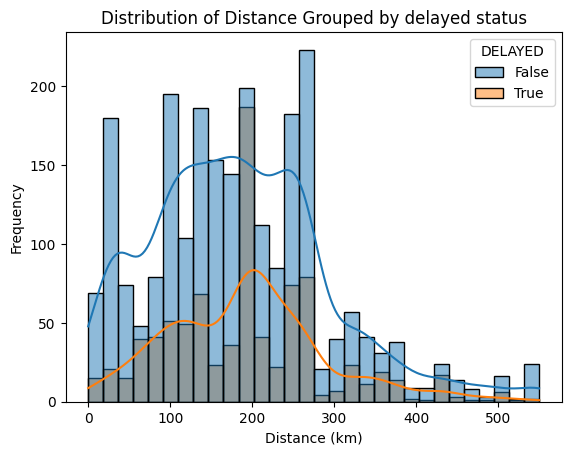

In [25]:
sns.histplot(data=shipment_bookings, x="DISTANCE", hue="DELAYED", kde=True, fill=True)
plt.title("Distribution of Distance Grouped by delayed status")
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.show()

#### Time feature engineering

Add features for duration and windows etc from collection/delivery datetimes.

In [26]:
# Extracting day of the week from the earliest collection date
shipment_bookings["COLLECTION_DAY"] = shipment_bookings[
    "FIRST_COLLECTION_SCHEDULE_EARLIEST"
].dt.day_name()
# Extracting day of the week from the latest delivery date
shipment_bookings["DELIVERY_DAY"] = shipment_bookings[
    "LAST_DELIVERY_SCHEDULE_LATEST"
].dt.day_name()
# Extracting the hour of the day from the latest delivery date
shipment_bookings["DELIVERY_HOUR"] = shipment_bookings[
    "LAST_DELIVERY_SCHEDULE_LATEST"
].dt.hour

print(f"Min booking hour: {shipment_bookings['DELIVERY_HOUR'].min()}")
print(f"Max booking hour: {shipment_bookings['DELIVERY_HOUR'].max()}")
# Durations
# Delivery window duration
shipment_bookings["DELIVERY_WINDOW_DURATION"] = (
    shipment_bookings["LAST_DELIVERY_SCHEDULE_LATEST"]
    - shipment_bookings["LAST_DELIVERY_SCHEDULE_EARLIEST"]
).dt.total_seconds() / 3600

# Shipment duration
shipment_bookings["SHIPMENT_DURATION"] = (
    shipment_bookings["LAST_DELIVERY_SCHEDULE_LATEST"]
    - shipment_bookings["FIRST_COLLECTION_SCHEDULE_EARLIEST"]
).dt.total_seconds() / 3600

# shipment_bookings["DURATION_PER_DISTANCE"] = (
#     shipment_bookings["SHIPMENT_DURATION"].div(shipment_bookings["DISTANCE"])
# )

# print(f"Min duration per unit distance: {shipment_bookings["DURATION_PER_DISTANCE"].min()}")
# print(f"Max duration per unit distance: {shipment_bookings["DURATION_PER_DISTANCE"].max()}")

Min booking hour: 0
Max booking hour: 23


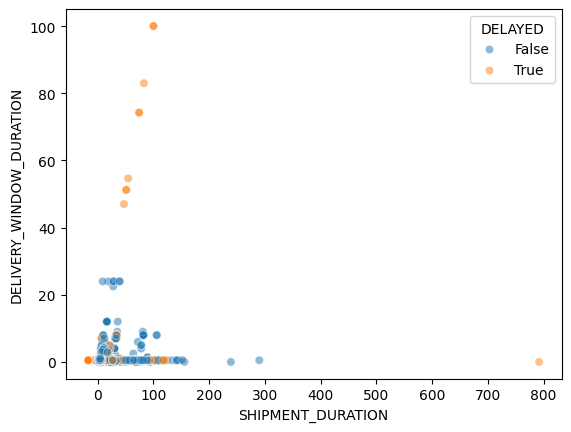

In [27]:
# Duration and delivery window length
sns.scatterplot(
    data=shipment_bookings,
    x="SHIPMENT_DURATION",
    y="DELIVERY_WINDOW_DURATION",
    hue="DELAYED",
    alpha=0.5,
)
plt.show()

In [28]:
# # Drop delivery windows over 24 hours
# shipment_bookings = shipment_bookings[
#     shipment_bookings["DELIVERY_WINDOW_DURATION"] <= 24
# ]
# Drop shipment durations over 180 days
# shipment_bookings = shipment_bookings[shipment_bookings["SHIPMENT_DURATION"] <= 180]

# Inspect 0 and negative shipment durations
shipment_bookings.loc[
    shipment_bookings["SHIPMENT_DURATION"] <= 0,
    [
        "SHIPMENT_NUMBER",
        "FIRST_COLLECTION_SCHEDULE_EARLIEST",
        "LAST_DELIVERY_SCHEDULE_LATEST",
        "SHIPMENT_DURATION",
    ],
]

,SHIPMENT_NUMBER,FIRST_COLLECTION_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST,SHIPMENT_DURATION
319,SEZHUK-231220-276089,2023-12-21 19:00:00+00:00,2023-12-21 10:45:00+00:00,-8.25
456,SEZHUK-231215-274563,2023-12-16 10:00:00+00:00,2023-12-15 17:00:00+00:00,-17.00
537,SEZHUK-231215-274632,2023-12-17 20:00:00+00:00,2023-12-17 03:00:00+00:00,-17.00
802,SEZHUK-231215-274628,2023-12-16 10:00:00+00:00,2023-12-15 17:00:00+00:00,-17.00
850,SEZHUK-231215-274570,2023-12-17 18:00:00+00:00,2023-12-17 01:00:00+00:00,-17.00
926,SEZHUK-231216-274798,2023-12-21 03:30:00+00:00,2023-12-20 23:00:00+00:00,-4.50
1091,SEZHUK-231215-274639,2023-12-16 10:00:00+00:00,2023-12-15 17:00:00+00:00,-17.00
1858,SEZHUK-231018-253947,2023-10-18 14:00:00+00:00,2023-10-18 11:00:00+00:00,-3.00
2462,SEZHUK-231205-269918,2023-12-06 06:00:00+00:00,2023-12-06 06:00:00+00:00,0.00
3062,SEZHUK-231212-272610,2023-12-13 18:30:00+00:00,2023-12-13 01:30:00+00:00,-17.00


In [29]:
# # Drop shipments with 0 or negative durations
# shipment_bookings = shipment_bookings[shipment_bookings["SHIPMENT_DURATION"] > 0]

In [30]:
shipment_bookings["DELAYED"] = shipment_bookings["DELAYED"].astype(int)

In [31]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    shipment_bookings.drop("DELAYED", axis=1),
    shipment_bookings["DELAYED"],
    test_size=0.2,
    random_state=101,
)

In [32]:
X_train = pd.concat([X_train, y_train], axis=1)

In [33]:
# Vehicle sizes
X_train["VEHICLE_SIZE"].unique()

array(['Tractor Unit', '3.5T Van', '3.5 T Van', '26T Rigid', '18T Rigid',
       '7.5T Rigid'], dtype=object)

In [34]:
# Clean up VEHICLE_SIZE column
def clean_vehicle_size(vehicle_size: pd.Series) -> pd.Series:
    return vehicle_size.str.replace(" ", "")


X_train["VEHICLE_SIZE"] = clean_vehicle_size(X_train["VEHICLE_SIZE"])
X_test["VEHICLE_SIZE"] = clean_vehicle_size(X_test["VEHICLE_SIZE"])
X_train["VEHICLE_SIZE"].unique()

array(['TractorUnit', '3.5TVan', '26TRigid', '18TRigid', '7.5TRigid'],
      dtype=object)

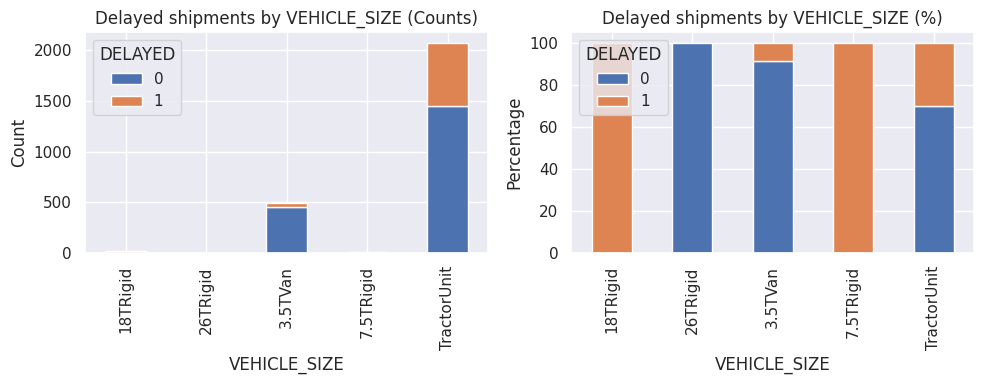

In [35]:
plot_bars("VEHICLE_SIZE", data=X_train)
plt.show()

In [36]:
X_train["CARRIER_DISPLAY_ID"].nunique()

89

In [37]:
carrier_frequncies = X_train["CARRIER_DISPLAY_ID"].value_counts()

with open("../components/carrier_frequencies.pkl", "wb") as f:
    joblib.dump(carrier_frequncies, f)

In [38]:
labeller = LabelEncoder()

X_train["CARRIER_ID_CONDENSED"] = labeller.fit_transform(
    X_train["CARRIER_DISPLAY_ID"].apply(
        lambda x: x if carrier_frequncies[x] >= 5 else "OTHER"
    )
)

with open("../components/labeller.pkl", "wb") as f:
    joblib.dump(labeller, f)

In [39]:
X_train["CARRIER_ID_CONDENSED"].nunique()

51

In [40]:
mutual_info_classif(X_train[["CARRIER_ID_CONDENSED"]], X_train["DELAYED"])

array([0.10270755])

Even the courier column seems to give very little information about delays, so there are likely not reliable or unreliable couriers.

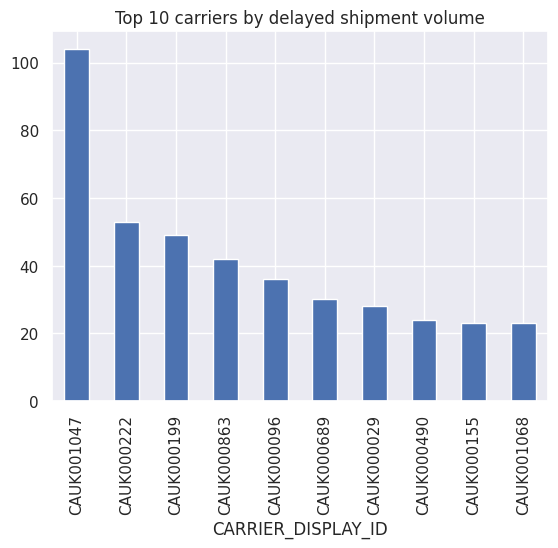

In [41]:
carrier_share = (
    X_train.groupby("CARRIER_DISPLAY_ID")["DELAYED"].sum().sort_values(ascending=False)
)
carrier_share[:10].plot.bar(title="Top 10 carriers by delayed shipment volume")
plt.show()

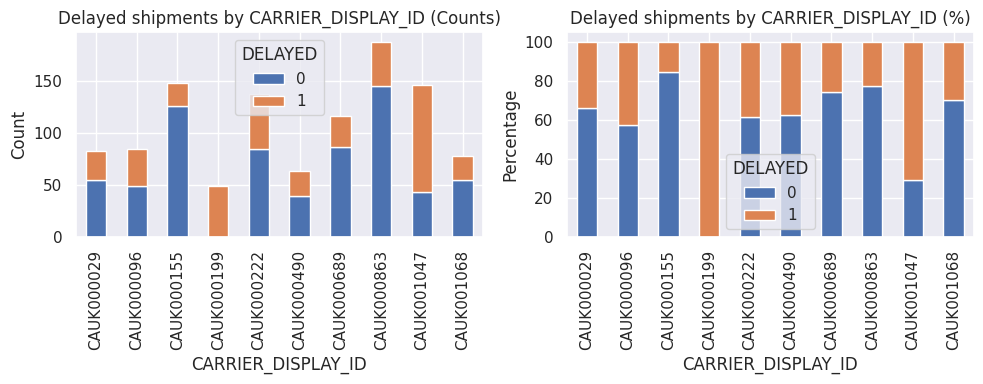

In [42]:
plot_bars(
    "CARRIER_DISPLAY_ID",
    data=X_train[X_train["CARRIER_DISPLAY_ID"].isin(carrier_share[:10].index)],
)

In [43]:
X_train["VEHICLE_BUILD_UP"].unique()

array(['Box', 'Curtain-Side 13.6M Trailer', 'LWB Van', '40ft Container',
       'Box 44ft', 'Tractor Only', 'Curtain Side', 'Double Deck Trailer',
       'Tractor Only 6x2', 'Temperature-Controlled', '20ft Container',
       'Box 40ft'], dtype=object)

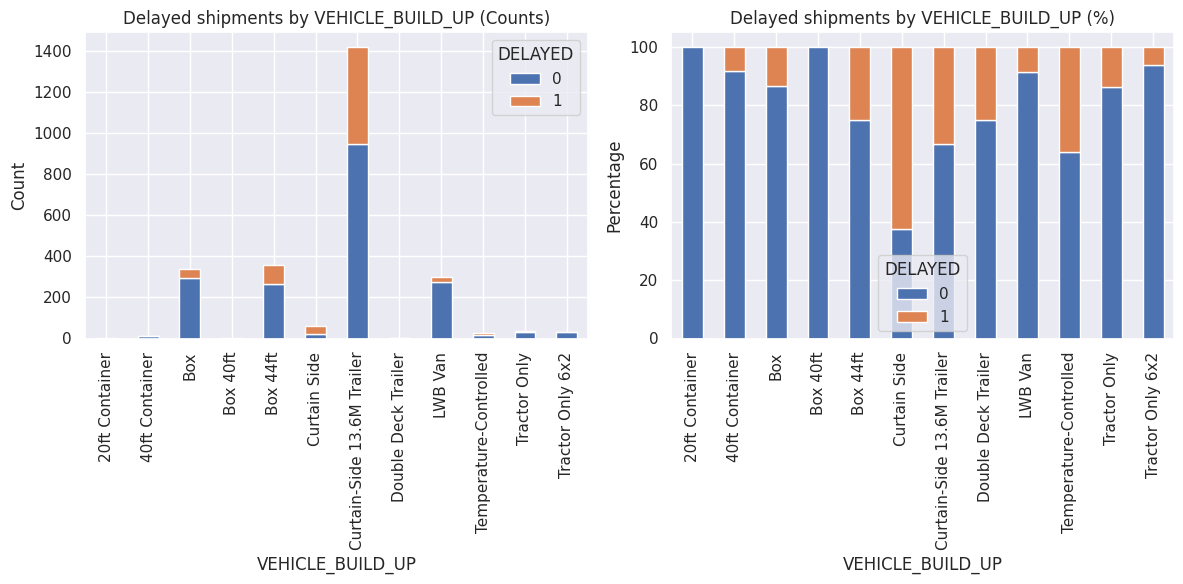

In [44]:
plot_bars("VEHICLE_BUILD_UP", data=X_train, figsize=(12, 6))

Differences between `VEHICLE_BUILD_UP` classifications aren't clear. In the real-world, a domain expert would give input into descriptions e.g. is `Box` the same as `Box 40ft` or `Box 44ft`, is `Curtain Side` the same as `Curtain Side 13.6M Trailer` etc. to determine how to handle this variable to better understand its predictive power.

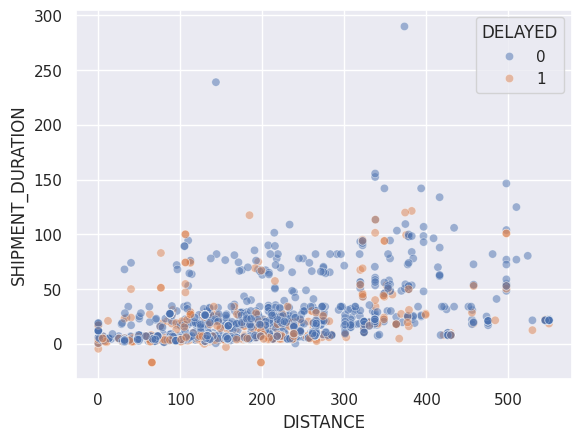

In [45]:
# Distance and shipment duration
sns.scatterplot(
    data=X_train,
    x="DISTANCE",
    y="SHIPMENT_DURATION",
    hue="DELAYED",
    alpha=0.5,
)
plt.show()

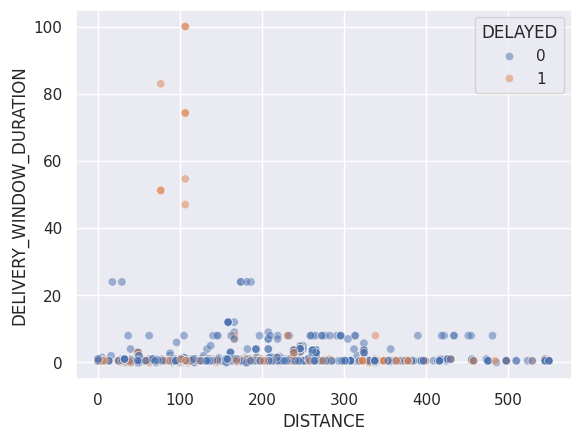

In [46]:
# Distance and Delivery window duration
sns.scatterplot(
    data=X_train,
    x="DISTANCE",
    y="DELIVERY_WINDOW_DURATION",
    hue="DELAYED",
    alpha=0.5,
)
plt.show()

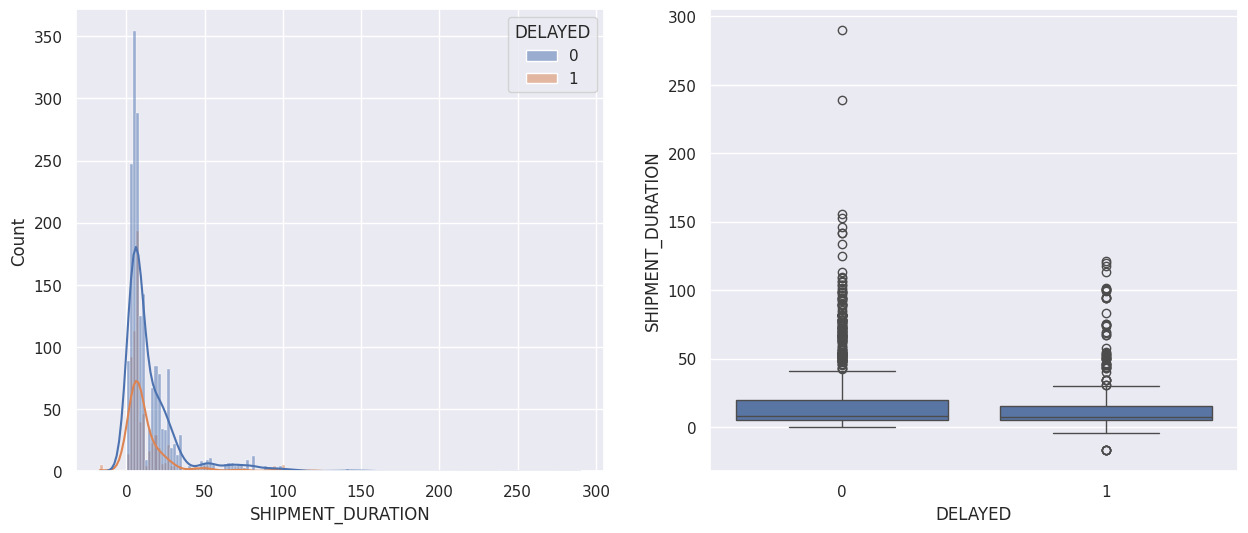

In [47]:
distplots("SHIPMENT_DURATION", data=X_train)

In [48]:
# distplots("DURATION_PER_DISTANCE", data=X_train[X_train["DURATION_PER_DISTANCE"] <= 0.5])

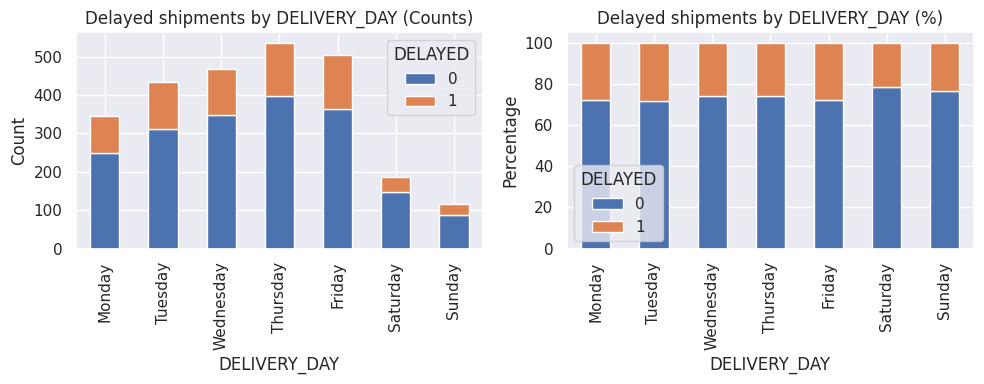

In [49]:
plot_bars(
    "DELIVERY_DAY",
    data=X_train,
    order=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
)
plt.show()

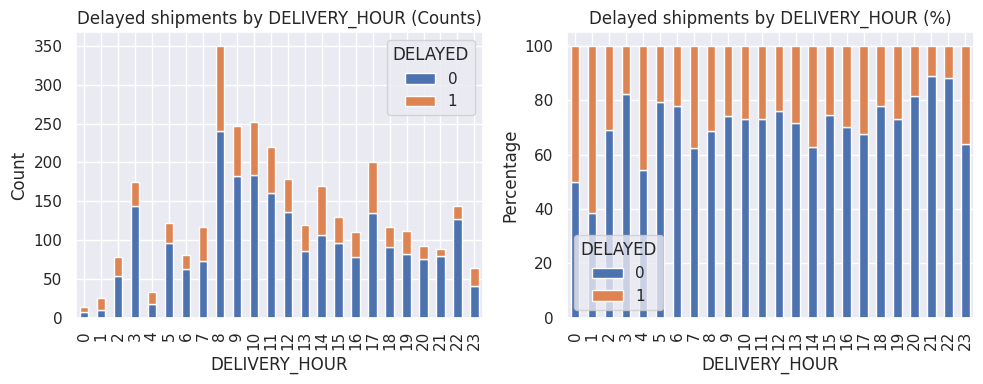

In [50]:
plot_bars("DELIVERY_HOUR", data=shipment_bookings)

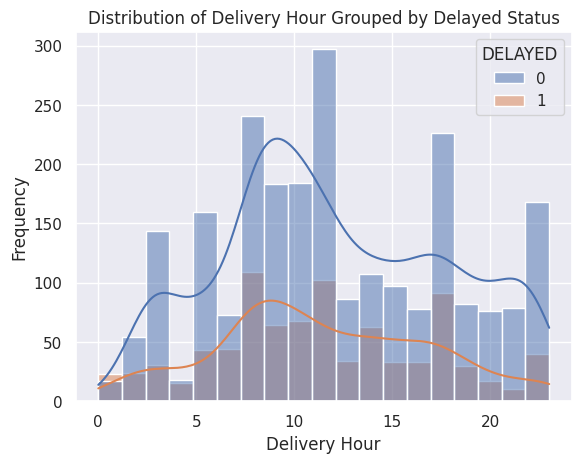

In [51]:
sns.histplot(
    data=shipment_bookings, x="DELIVERY_HOUR", hue="DELAYED", kde=True, fill=True
)
plt.title("Distribution of Delivery Hour Grouped by Delayed Status")
plt.xlabel("Delivery Hour")
plt.ylabel("Frequency")
plt.show()

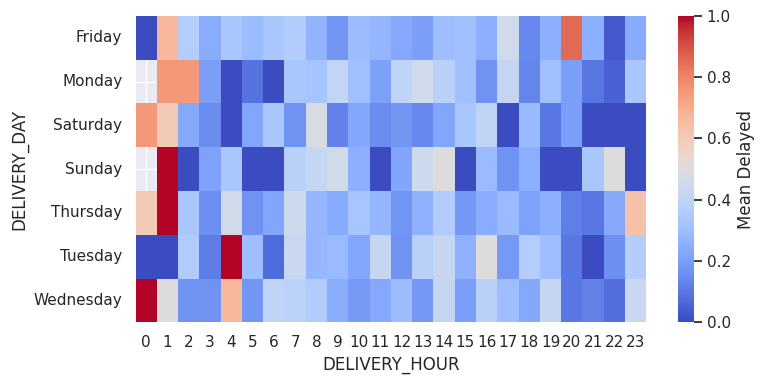

In [52]:
fix, ax = plt.subplots(figsize=(8, 4))
heatmap_data = (
    shipment_bookings.groupby(["DELIVERY_DAY", "DELIVERY_HOUR"])["DELAYED"]
    .mean()
    .reset_index()
)
heatmap_pivot = heatmap_data.pivot(
    columns=["DELIVERY_HOUR"], index=["DELIVERY_DAY"], values="DELAYED"
)
sns.heatmap(
    heatmap_pivot,
    cmap="coolwarm",
    annot=False,
    fmt=".1f",
    cbar_kws={"label": "Mean Delayed"},
)
plt.tight_layout()

/tmp/ipykernel_13144/2996681551.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shipment_bookings.groupby([duration_bins, window_bins])["DELAYED"].mean().unstack(),


<Axes: xlabel='DELIVERY_WINDOW_DURATION', ylabel='SHIPMENT_DURATION'>

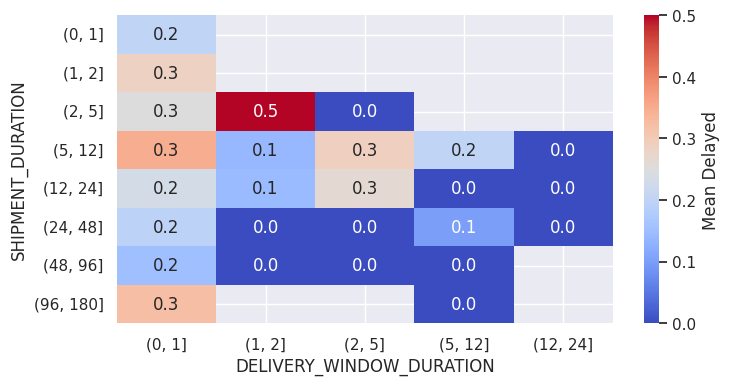

In [53]:
fix, ax = plt.subplots(figsize=(8, 4))
duration_bins = pd.cut(
    shipment_bookings["SHIPMENT_DURATION"], bins=[0, 1, 2, 5, 12, 24, 48, 96, 180]
)
window_bins = pd.cut(
    shipment_bookings["DELIVERY_WINDOW_DURATION"], bins=[0, 1, 2, 5, 12, 24]
)
sns.heatmap(
    shipment_bookings.groupby([duration_bins, window_bins])["DELAYED"].mean().unstack(),
    cmap="coolwarm",
    annot=True,
    fmt=".1f",
    cbar_kws={"label": "Mean Delayed"},
)

In [54]:
# Choose whether van or not
X_train["IS_VAN"] = X_train["VEHICLE_SIZE"].apply(lambda x: 1 if x == "3.5TVan" else 0)

X_test["IS_VAN"] = X_test["VEHICLE_SIZE"].apply(lambda x: 1 if x == "3.5TVan" else 0)

In [55]:
numeric_X_train = X_train.select_dtypes(include="number")
numeric_X_test = X_test.select_dtypes(include="number")
numeric_X_train.head()

,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,DISTANCE,DELIVERY_HOUR,DELIVERY_WINDOW_DURATION,SHIPMENT_DURATION,DELAYED,CARRIER_ID_CONDENSED,IS_VAN
1714,53.753295,-1.722689,51.398689,-1.232386,264.114503,2,0.500000,7.500000,0,7,0
3077,51.785961,-2.619676,53.295391,-1.066283,198.282622,2,0.500000,7.000000,0,48,0
853,51.582459,-3.043825,52.829374,-1.332134,181.491379,13,1.000000,5.000000,0,44,1
2230,51.742307,-0.219644,52.849282,-1.354253,145.475712,20,0.750278,6.000278,0,24,0
1330,53.767302,-1.746560,51.602415,-2.522567,246.554477,14,4.116667,11.033333,1,49,0


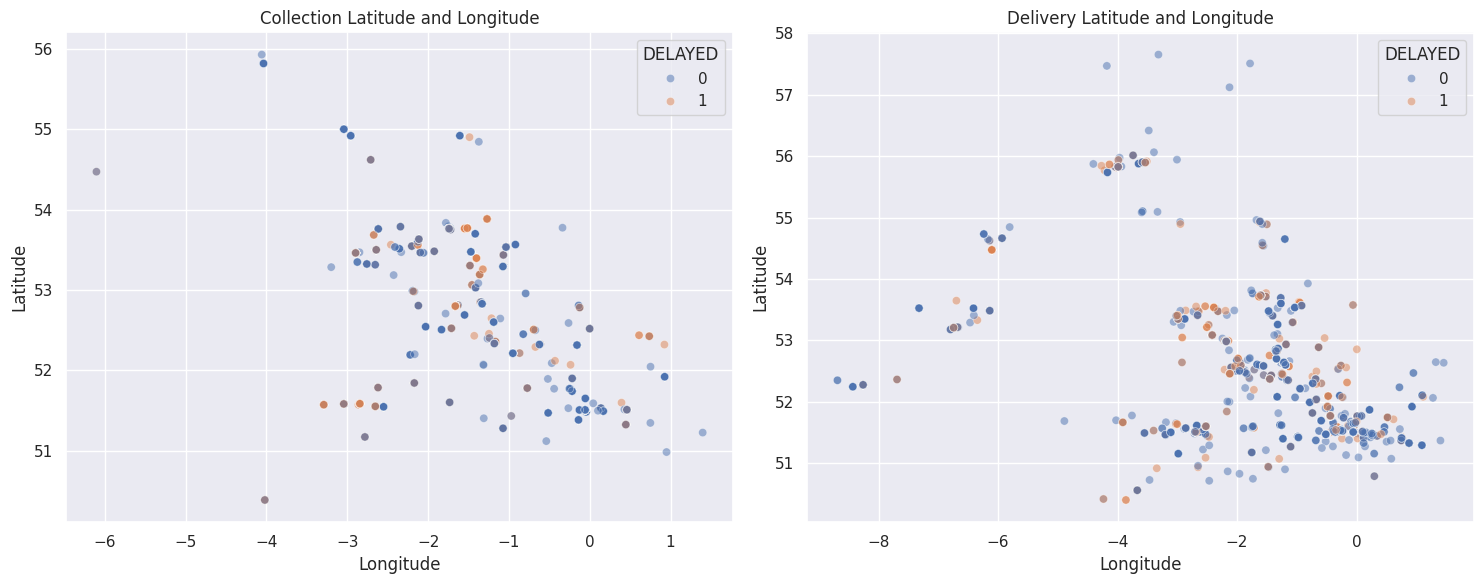

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot for collection latitude and longitude
sns.scatterplot(
    data=X_train,
    x="FIRST_COLLECTION_LONGITUDE",
    y="FIRST_COLLECTION_LATITUDE",
    hue="DELAYED",
    alpha=0.5,
    ax=axes[0],
)
axes[0].set_title("Collection Latitude and Longitude")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# Scatter plot for delivery latitude and longitude
sns.scatterplot(
    data=X_train,
    x="LAST_DELIVERY_LONGITUDE",
    y="LAST_DELIVERY_LATITUDE",
    hue="DELAYED",
    alpha=0.5,
    ax=axes[1],
)
axes[1].set_title("Delivery Latitude and Longitude")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

plt.tight_layout()
plt.show()

Lat/Lon does not appear to have any relation to delayed deliveries e.g. deliveries in London may have been more likely to be delayed due to traffic.

In [57]:
# Drop lat/lon information
numeric_X_train = numeric_X_train.drop(
    columns=[
        "FIRST_COLLECTION_LATITUDE",
        "FIRST_COLLECTION_LONGITUDE",
        "LAST_DELIVERY_LATITUDE",
        "LAST_DELIVERY_LONGITUDE",
    ]
)

numeric_X_test = numeric_X_test.drop(
    columns=[
        "FIRST_COLLECTION_LATITUDE",
        "FIRST_COLLECTION_LONGITUDE",
        "LAST_DELIVERY_LATITUDE",
        "LAST_DELIVERY_LONGITUDE",
    ]
)
numeric_X_train.head()

,DISTANCE,DELIVERY_HOUR,DELIVERY_WINDOW_DURATION,SHIPMENT_DURATION,DELAYED,CARRIER_ID_CONDENSED,IS_VAN
1714,264.114503,2,0.500000,7.500000,0,7,0
3077,198.282622,2,0.500000,7.000000,0,48,0
853,181.491379,13,1.000000,5.000000,0,44,1
2230,145.475712,20,0.750278,6.000278,0,24,0
1330,246.554477,14,4.116667,11.033333,1,49,0


In [58]:
numeric_X_train["IS_VAN"].mean()

np.float64(0.19113680154142582)

In [59]:
numeric_X_train.to_csv(f"{DATA_PATH}/training_data.csv", index=False)
numeric_X_test.to_csv(f"{DATA_PATH}/test_data.csv", index=False)

In [60]:
# Creating a version with lat lon for use with distancematrix.ai
X_train.to_csv(f"{DATA_PATH}/training_data_with_lat_lon.csv", index=False)

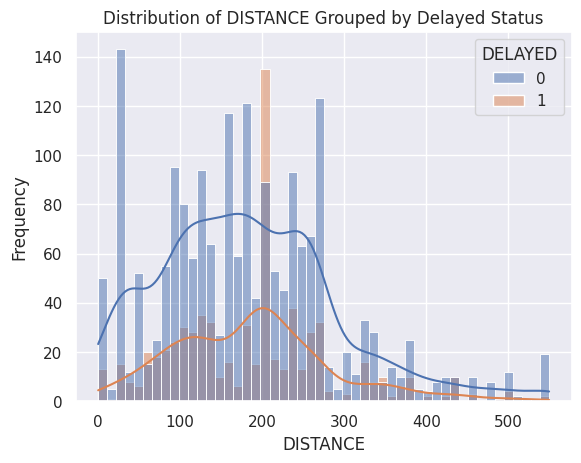

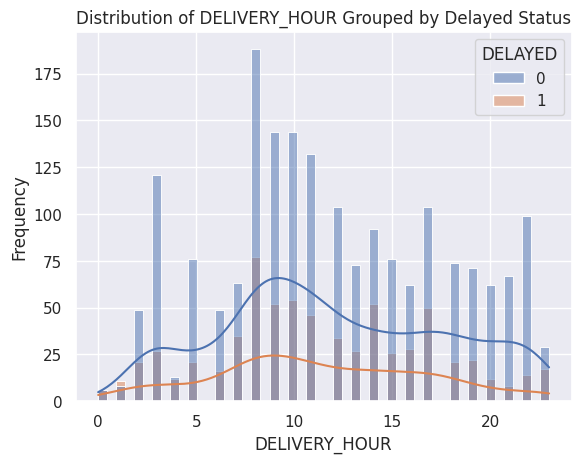

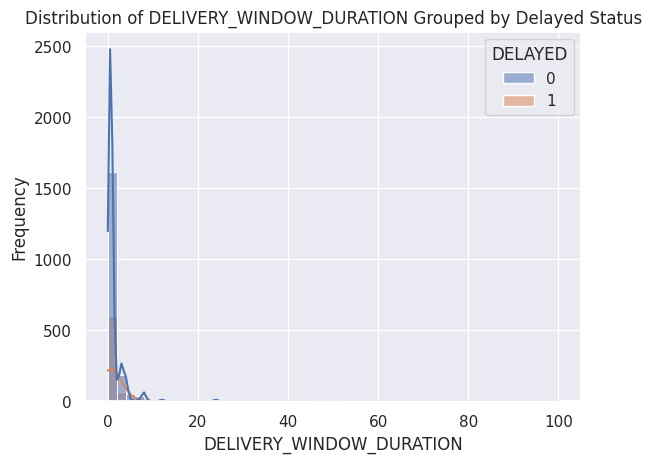

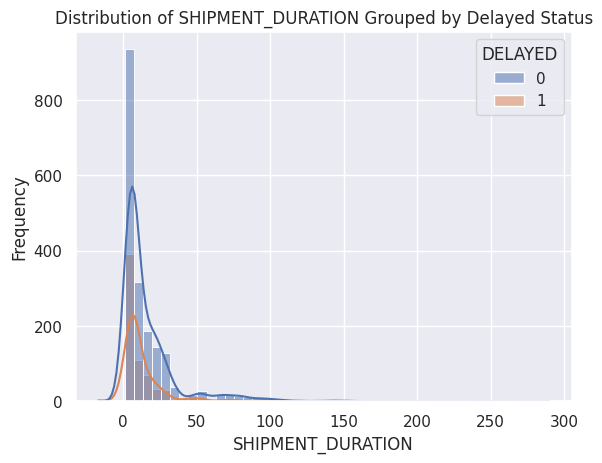

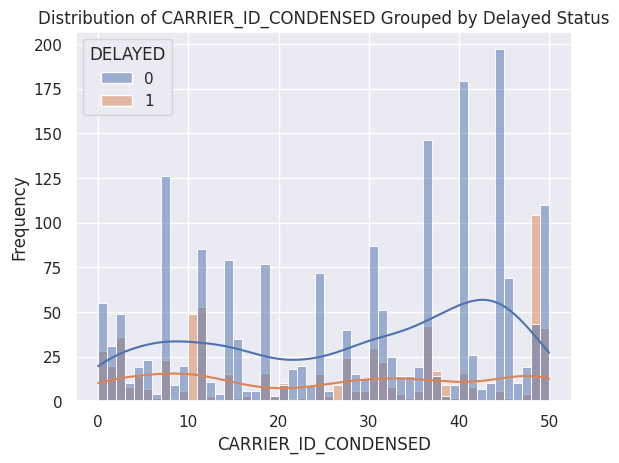

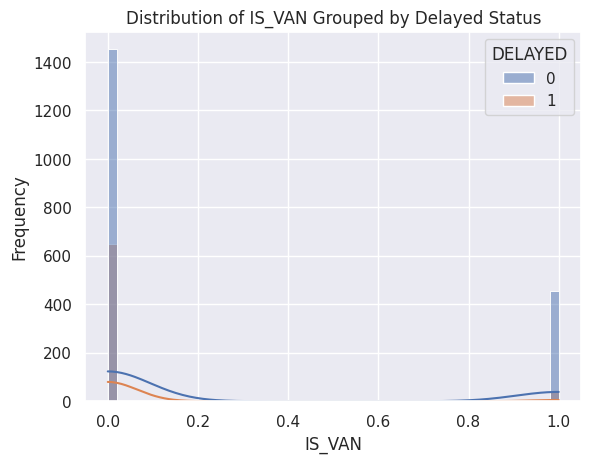

In [61]:
for column in numeric_X_train.drop(columns="DELAYED").columns:
    sns.histplot(
        data=numeric_X_train, x=column, kde=True, fill=True, hue="DELAYED", bins=50
    )
    plt.title(f"Distribution of {column} Grouped by Delayed Status")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

In [62]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method="yeo-johnson")
transformed_cols = pd.DataFrame(
    pt.fit_transform(
        numeric_X_train[["SHIPMENT_DURATION", "DELIVERY_WINDOW_DURATION", "DISTANCE"]],
    ),
    columns=["SHIPMENT_DURATION", "DELIVERY_WINDOW_DURATION", "DISTANCE"],
)

with open("../components/power_transformer.pkl", "wb") as f:
    joblib.dump(pt, f)

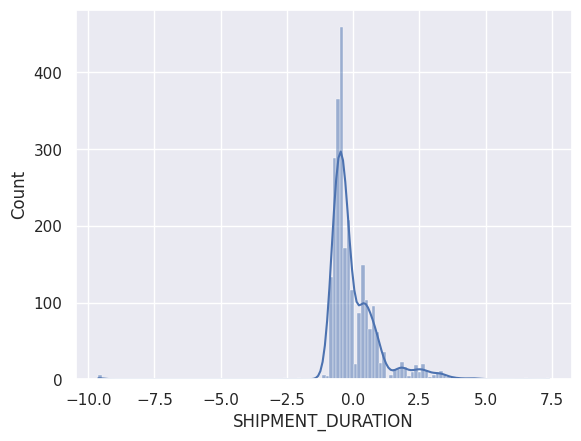

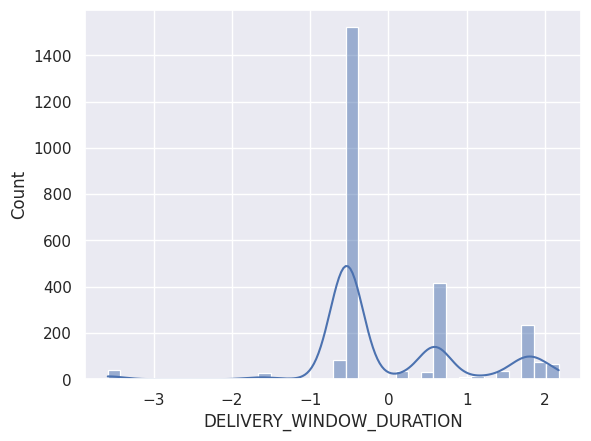

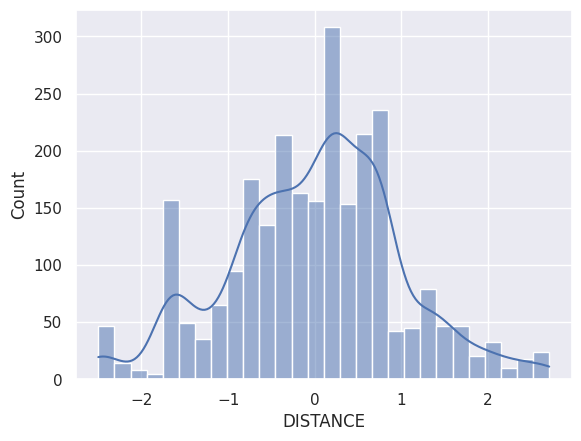

In [63]:
for col in transformed_cols.columns:
    sns.histplot(transformed_cols[col], kde=True, fill=True)
    plt.show()